In [1]:
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets

import warnings
warnings.filterwarnings("ignore")

In [2]:

df_raw = pd.read_csv('/home/mw/input/Data9761/Data_Sum_HPP_Multi_Site_Share.csv')



df = df_raw[df_raw["Site"] == "METU"]


# 用 sex anxiety 来预测 romantic
df = df[["anxiety", "sex", "romantic"]]


df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

df["sex"] =  np.where(df['sex'] == 2, 1, 0)

df["index"] = range(len(df))
df = df.set_index("index")

In [3]:
df

,anxiety,sex,romantic
index,,,
0,2.666667,0,1
1,3.944444,1,0
2,4.388889,1,1
3,4.777778,1,0
4,3.000000,1,1
...,...,...,...
176,4.388889,1,0
177,4.166667,1,1
178,4.277778,1,1


In [4]:
plt.hist(df["romantic"])
plt.xticks([0,1])
plt.xlabel("romantic")
plt.ylabel("count")
sns.despine()
plt.show()

<Figure size 640x480 with 1 Axes>

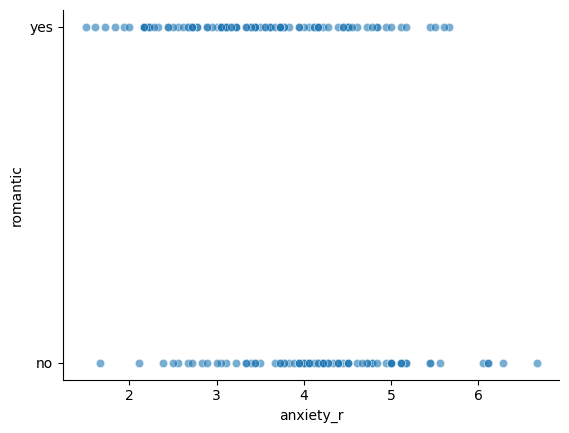

In [5]:

sns.scatterplot(data=df,
                x="anxiety",
                y="romantic",
                alpha=0.6)

plt.xlabel("anxiety_r")

plt.yticks([0,1],['no','yes'])
sns.despine()

In [5]:
df


,anxiety,sex,romantic
index,,,
0,2.666667,0,1
1,3.944444,1,0
2,4.388889,1,1
3,4.777778,1,0
4,3.000000,1,1
...,...,...,...
176,4.388889,1,0
177,4.166667,1,1
178,4.277778,1,1


In [7]:
# 直接建四个模型了 两个单因素 一个无交互 一个有交互 都看看效果


with pm.Model() as model_jiaohu:
    model_jiaohu.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)                
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    beta_s = pm.Normal("beta_s", mu=0, sigma=5)
    beta_a_s = pm.Normal("beta_a_s", mu=0, sigma=1)      
    sigma = pm.Exponential("sigma", 0.6)                 

    sex = pm.MutableData("sex",df.sex, dims="obs_id") 
    anxiety  = pm.MutableData("anxiety",df.anxiety, dims="obs_id")                 
    mu = pm.Deterministic("mu", beta_0 + beta_a*anxiety + beta_s*sex +beta_a_s*anxiety*sex, dims="obs_id") 
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')    


    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")       

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
    
with pm.Model() as model_a:
    model_a.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)                
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)    
    sigma = pm.Exponential("sigma", 0.6)                 

    anxiety = pm.MutableData("anxiety",df.anxiety, dims="obs_id")              
    mu = pm.Deterministic("mu", beta_0 + beta_a*anxiety, dims="obs_id") 
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')    


    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")       

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
with pm.Model() as model_s:
    model_s.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)                
    beta_s = pm.Normal("beta_s", mu=0, sigma=5)    
    sigma = pm.Exponential("sigma", 0.6)                 

    sex = pm.MutableData("sex",df.sex, dims="obs_id")                 
    mu = pm.Deterministic("mu", beta_0 + beta_s*sex , dims="obs_id") 
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')    


    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")       

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
    
with pm.Model() as model_as:
    model_as.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)                
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    beta_s = pm.Normal("beta_s", mu=0, sigma=5)     
    sigma = pm.Exponential("sigma", 0.6)                 

    sex = pm.MutableData("sex",df.sex, dims="obs_id") 
    anxiety  = pm.MutableData("anxiety",df.anxiety, dims="obs_id")                 
    mu = pm.Deterministic("mu", beta_0 + beta_a*anxiety + beta_s*sex , dims="obs_id") 
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')    


    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")       

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    

In [43]:
with model_a:
    model_a_trace = pm.sample(draws=5000,                  # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,
                      idata_kwargs={"log_likelihood": True},# tune的结果将在采样结束后被丢弃
                      random_seed=84735)

with model_s:
    model_s_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                   # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                    # 链数
                        discard_tuned_samples= True,
                        idata_kwargs={"log_likelihood": True},
                        random_seed=84735)
    
with model_as:
    model_as_trace = pm.sample(draws=5000,                  # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True, 
                      idata_kwargs={"log_likelihood": True},# tune的结果将在采样结束后被丢弃
                      random_seed=84735)

with model_jiaohu:
    model_jiaohu_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                   # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                    # 链数
                        discard_tuned_samples= True,
                        idata_kwargs={"log_likelihood": True},# tune的结果将在采样结束后被丢弃
                        random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_a, sigma]


KeyboardInterrupt: 

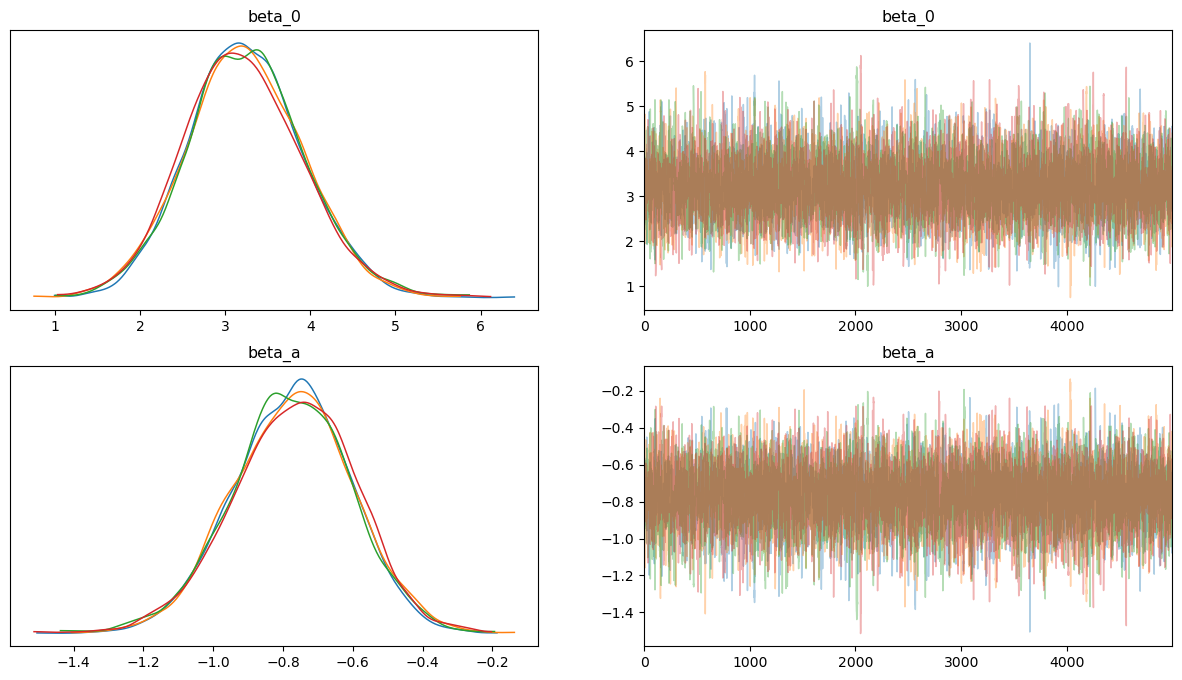

In [49]:
az.plot_trace(model_a_trace,
              var_names=["beta_0","beta_a"],
              figsize=(15,8),
              compact=False)
plt.show()

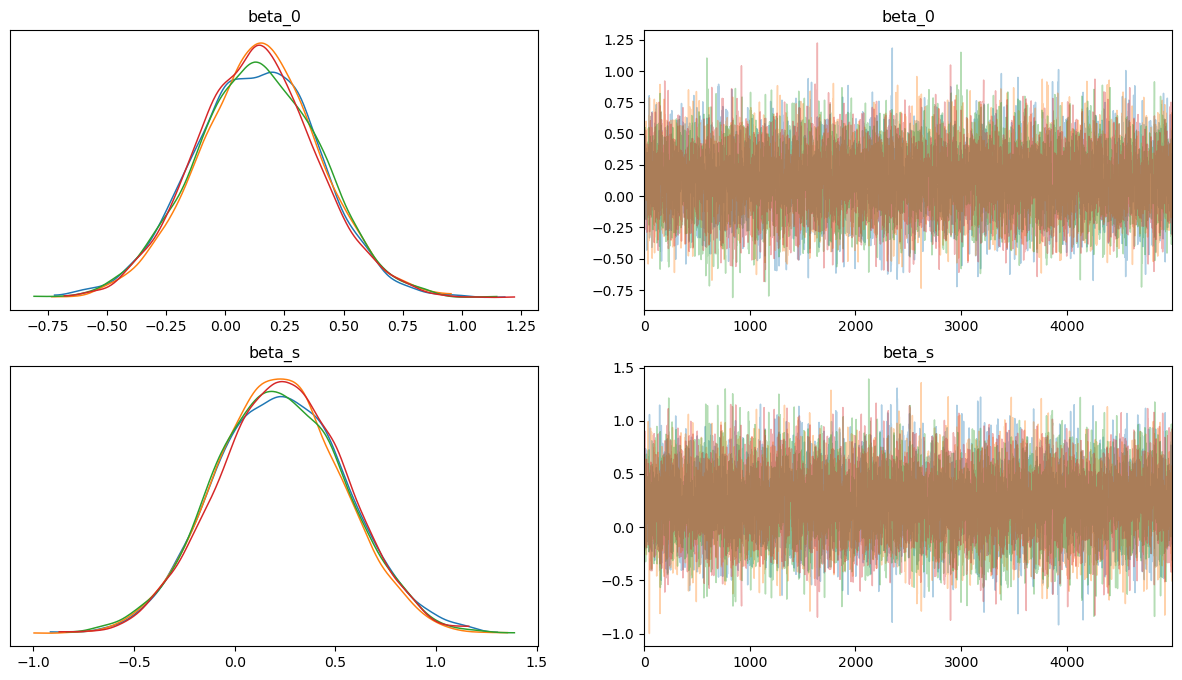

In [50]:
az.plot_trace(model_s_trace,
              var_names=["beta_0","beta_s"],
              figsize=(15,8),
              compact=False)
plt.show()

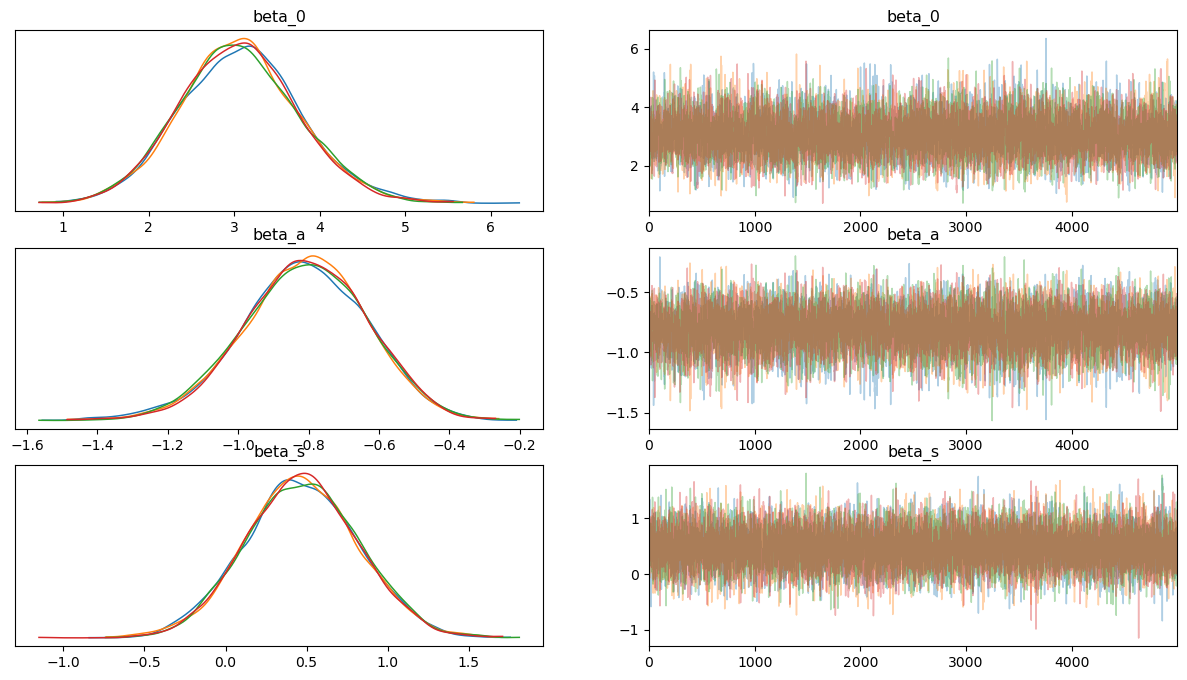

In [51]:
az.plot_trace(model_as_trace,
              var_names=["beta_0","beta_a","beta_s"],
              figsize=(15,8),
              compact=False)
plt.show()

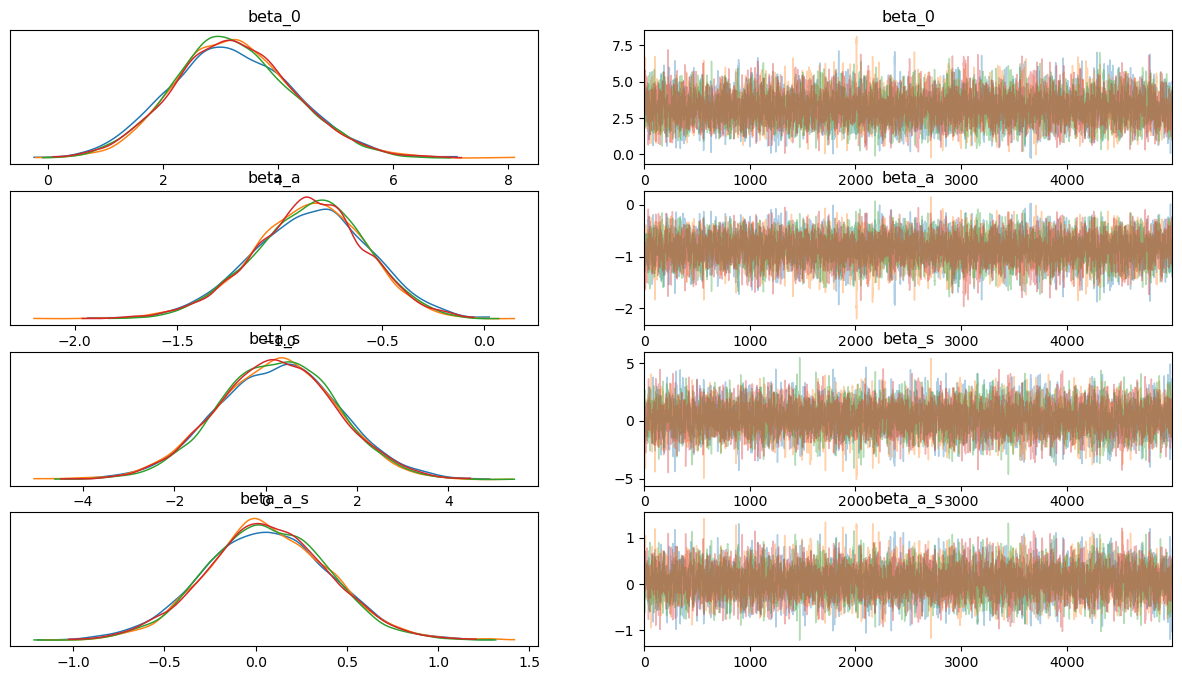

In [52]:
az.plot_trace(model_jiaohu_trace,
              var_names=["beta_0","beta_a","beta_s","beta_a_s"],
              figsize=(15,8),
              compact=False)
plt.show()

In [53]:
az.summary(model_jiaohu_trace, var_names=["beta_0","beta_a","beta_s","beta_a_s"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.223,1.051,1.289,5.225,0.014,0.010,5339.0,7565.0,1.0
beta_a,-0.855,0.279,-1.372,-0.324,0.004,0.003,5384.0,7815.0,1.0
beta_s,0.236,1.304,-2.172,2.712,0.018,0.013,5338.0,7940.0,1.0
beta_a_s,0.064,0.336,-0.581,0.683,0.005,0.003,5242.0,7912.0,1.0


In [54]:
az.summary(model_s_trace, var_names=["beta_0","beta_s"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.134,0.258,-0.356,0.613,0.003,0.002,8512.0,10033.0,1.0
beta_s,0.225,0.318,-0.374,0.820,0.003,0.002,8455.0,10485.0,1.0


In [55]:
az.summary(model_a_trace, var_names=["beta_0","beta_a"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.233,0.686,1.952,4.528,0.008,0.006,6966.0,6873.0,1.0
beta_a,-0.773,0.173,-1.094,-0.445,0.002,0.002,6998.0,6931.0,1.0


In [56]:
az.summary(model_as_trace, var_names=["beta_0","beta_a","beta_s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.065,0.701,1.749,4.398,0.008,0.005,8690.0,8934.0,1.0
beta_a,-0.810,0.178,-1.148,-0.486,0.002,0.001,8692.0,9156.0,1.0
beta_s,0.470,0.350,-0.192,1.121,0.003,0.002,13880.0,12425.0,1.0


In [57]:
comparison_list = {
    "model1(a)":model_a_trace,
    "model2(s)":model_s_trace,
    "model3(as )":model_as_trace,
    "model4(jiaohu)":model_jiaohu_trace,
}
az.compare(comparison_list)

# 结果显示单因素a的模型似乎是最好的 交互项模型中的交互项系数95%的hdi里包括了0

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1(contiunous),0,-114.118280,2.032603,0.000000,5.635409e-01,4.950490,0.000000,False,log
model3(multivariate ),1,-114.297466,3.141796,0.179186,3.963343e-01,5.186817,1.396637,False,log
model4(interaction),2,-115.187169,4.095966,1.068889,5.229004e-15,5.294927,1.475632,False,log
model2(category),3,-125.511330,2.043437,11.393050,4.012483e-02,2.021288,4.815916,False,log


In [9]:
with model_a:
    modela_ppc = pm.sample_posterior_predictive(model_a_trace)
    
with model_s:
    models_ppc = pm.sample_posterior_predictive(model_s_trace)
    
with model_as:
    modelas_ppc = pm.sample_posterior_predictive(model_as_trace)
    
with model_jiaohu:
    modeljh_ppc = pm.sample_posterior_predictive(model_jiaohu_trace)


Sampling: [y_est]


Sampling: [y_est]


Sampling: [y_est]


Sampling: [y_est]


In [59]:
from statistics import median
def MAE(model_ppc):
    
    pre_x = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_x.mean(axis=1).values

    
    MAE = pd.DataFrame({
        "scontrol_ppc_mean": pre_y_mean,
        "scontrol_original": df.romantic
    })

    
    MAE["pre_error"] = abs(MAE["scontrol_original"] -\
                            MAE["scontrol_ppc_mean"])

    
    MAE = median(MAE.pre_error)
    return MAE

for x in [modela_ppc,models_ppc,modelas_ppc,modeljh_ppc]:
    print(MAE(x))

# a的MAE 也是较小的 

0.41169999999999995
0.46830000000000005
0.41795
0.40835


In [60]:
def counter_outlier(model_ppc, hdi_prob=0.95):
    
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    
    y_obs = model_ppc.observed_data["y_est"].values

   
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num
for x in [modela_ppc,models_ppc,modelas_ppc,modeljh_ppc]:
    print(counter_outlier(x))

181
181
181
181


array([<Axes: title={'center': 'beta_0'}>,
       <Axes: title={'center': 'beta_a'}>], dtype=object)

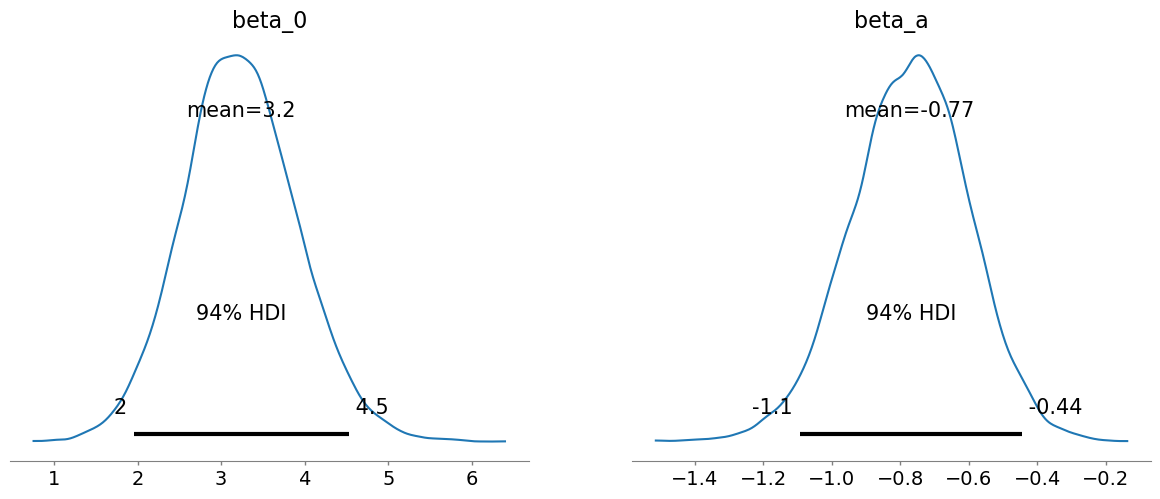

In [81]:
az.plot_posterior(model_a_trace, var_names=["beta_0","beta_a"])

array([<Axes: title={'center': 'beta_0'}>,
       <Axes: title={'center': 'beta_a'}>,
       <Axes: title={'center': 'beta_s'}>,
       <Axes: title={'center': 'beta_a_s'}>], dtype=object)

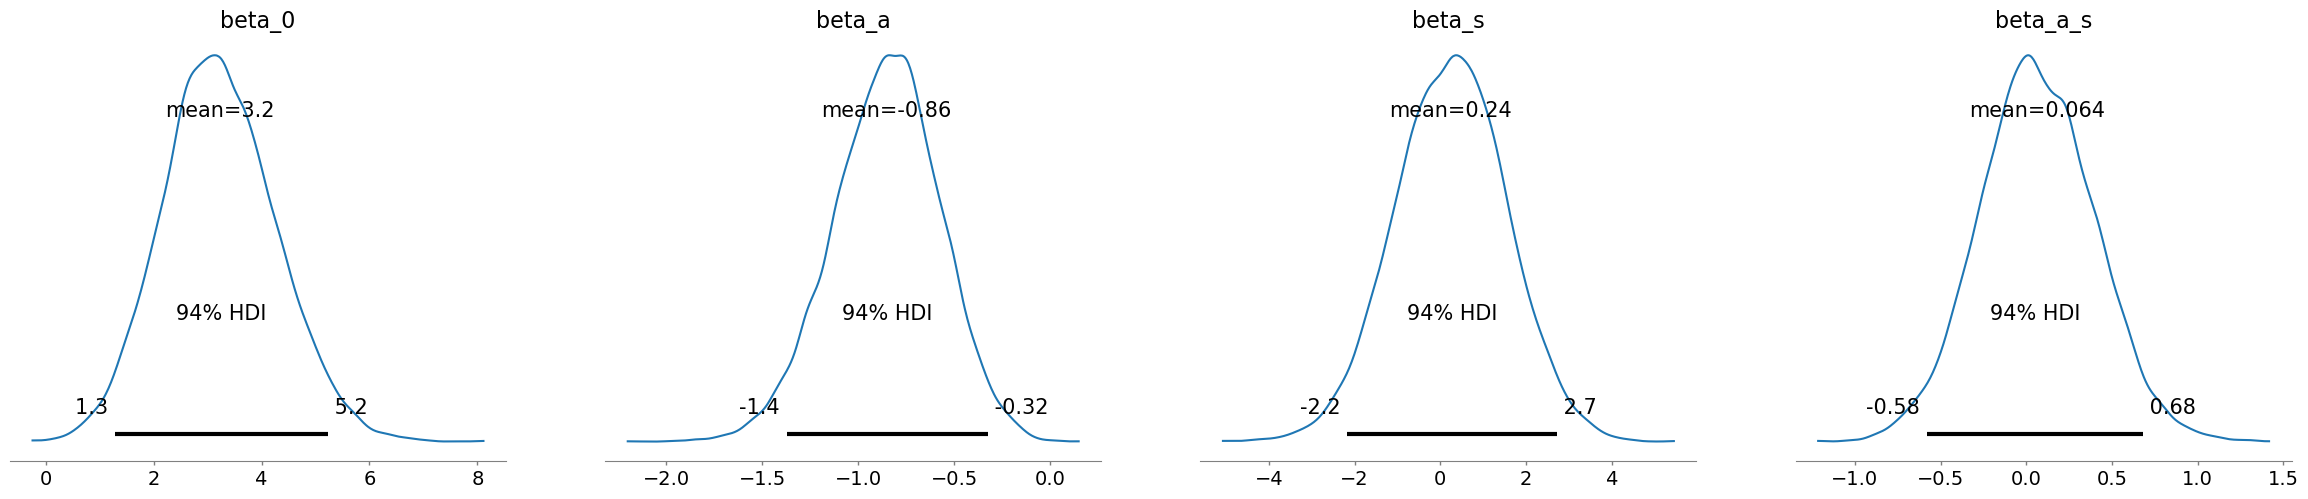

In [66]:
az.plot_posterior(model_jiaohu_trace, var_names=["beta_0","beta_a","beta_s","beta_a_s"]) #进一步验证了观点 综合来看a是最好的

<Axes: xlabel='y_est / y_est'>

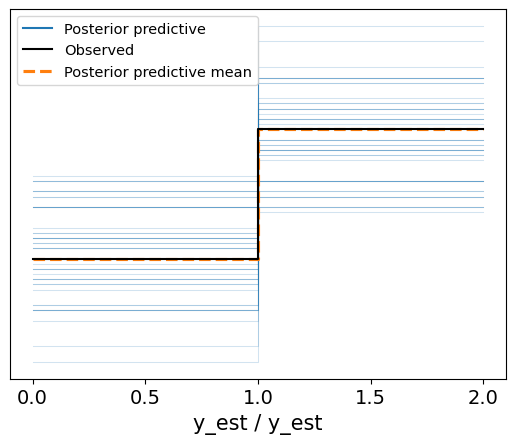

In [61]:
az.plot_ppc(modela_ppc, num_pp_samples=50)

In [10]:
modela_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw"))
modela_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [11]:
# 传入数据，假设一个人anxiety = 0看一下单因素a模型的拟合情况
pred_coords ={"obs_id":range(174,175)} 

with model_a:
    # 传入数据
    pm.set_data({"anxiety": np.array([1]),
                 "y": np.array([0])},
                coords=pred_coords
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(model_a_trace, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)
    
prediction

Sampling: [y_est]


Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

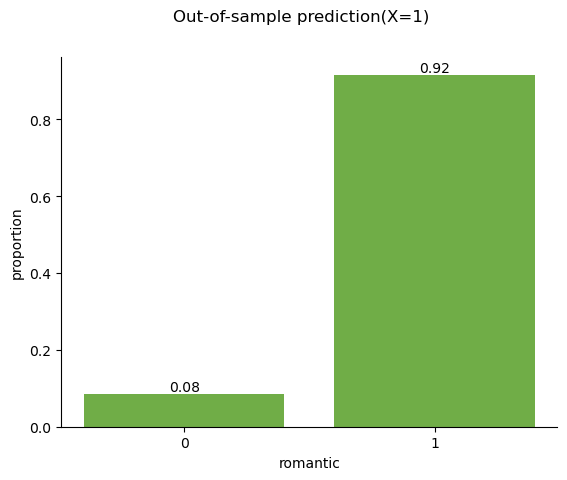

In [12]:

y_pred = prediction.predictions["y_est"].stack(sample=("chain","draw","obs_id")).values

y_pred_freq = np.bincount(y_pred)/len(y_pred)

bars = plt.bar([0, 1], y_pred_freq, color="#70AD47")

for bar, freq in zip(bars, y_pred_freq):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{freq:.2f}", ha='center', va='bottom')

plt.xticks([0, 1])
plt.suptitle("Out-of-sample prediction(X=1)")
plt.xlabel("romantic")
plt.ylabel("proportion")
sns.despine()

# 模型认为很大可能是1，难道不焦虑的人都是谈恋爱的？

In [83]:
# 搞一下分辨能力的矩阵
pred_pi = modela_ppc.posterior_predictive.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")

pred_pi = pred_pi.to_dataframe()





pred_pi["anxiety"] = modela_ppc.constant_data.anxiety.values
pred_pi["romantic"] = modela_ppc.observed_data.y_est.values


pred_pi["romantic_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi


confusion_matrix = pd.crosstab(pred_pi["romantic"], pred_pi["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix



Predicted,0,1
Actual,,
0,38,40
1,24,79


In [67]:
# 计算a b c d的数量
true_positive = 79
false_positive = 40
true_negative = confusion_matrix.at[0, 0]
false_negative = confusion_matrix.at[1, 0]
# 代入公式
accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.3870967741935484
敏感性: 0.0
特异性: 1.0


In [12]:
# 用我们的模型预测一下其他站点的数据 为了方便重新建一下单因素a的模型
df_raw = pd.read_csv('/home/mw/input/Data9761/Data_Sum_HPP_Multi_Site_Share.csv')



df = df_raw[df_raw["Site"] == "METU"]



df = df[["anxiety", "sex", "romantic"]]


df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

df["sex"] =  np.where(df['sex'] == 2, 1, 0)

df["index"] = range(len(df))
df = df.set_index("index")
with pm.Model() as model_a:
    model_a.add_coord('obs_id',df.index, mutable=True)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)                
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)    
    sigma = pm.Exponential("sigma", 0.6)                 

    anxiety = pm.MutableData("anxiety",df.anxiety, dims="obs_id")              
    mu = pm.Deterministic("mu", beta_0 + beta_a*anxiety, dims="obs_id") 
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')    
   
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")       

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
    model_a_trace = pm.sample(draws=5000,                  # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,
                      idata_kwargs={"log_likelihood": True},# tune的结果将在采样结束后被丢弃
                      random_seed=84735)
    
    modela_ppc = pm.sample_posterior_predictive(model_a_trace)
    
    
modela_ppc

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_a, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 43 seconds.
Sampling: [y_est]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [13]:
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')



df = df_raw[df_raw["Site"] == "UCSB"]



df = df[["anxiety", "sex", "romantic"]]


df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

df["sex"] =  np.where(df['sex'] == 2, 1, 0)

df["index"] = range(len(df))
df = df.set_index("index")

pred_coords ={"obs_id":df.index} 

with model_a:
    # 传入其他站点数据
    pm.set_data({"anxiety": df.anxiety.values,
                 "y": df.romantic.values},
                coords=pred_coords
                )   
    # 生成对因变量的预测
    prediction = pm.sample_posterior_predictive(model_a_trace, 
                                                var_names=["y_est"],
                                                predictions=True,
                                                random_seed=84735,
                                                extend_inferencedata=True)
    




Sampling: [y_est]


In [23]:
prediction.predictions_constant_data.y

<xarray.DataArray 'y' (obs_id: 108)>
array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])
Coordinates:
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 7 ... 100 101 102 103 104 105 106 107

In [30]:
#stack(sample = ("chain", "draw")：将每一个X对应的4*5000个后验预测值合并到一个维度sample
#对于每一个X，需要计算其20000个值的平均值，因此将dim设置为sample
pred_pi = prediction.predictions.y_est.stack(sample = ("chain", "draw")).mean(dim="sample")
# 转换为数据框
pred_pi = pred_pi.to_dataframe()

#将原数据中的X 和Y存入数据框
pred_pi["anxiety"] = prediction.predictions_constant_data.anxiety.values
pred_pi["romantic"] = prediction.predictions_constant_data.y.values
#根据分类标准（50-50）生成最终的分类结果
pred_pi["romantic_pred"] = np.where(pred_pi["y_est"] >= 0.5, 1, 0)
pred_pi








,y_est,anxiety,romantic,romantic_pred
obs_id,,,,
0,0.89900,1.222222,0,1
1,0.71830,2.944444,1,1
2,0.87045,1.666667,0,1
3,0.61900,3.555556,0,1
4,0.44995,4.444444,1,0
...,...,...,...,...
103,0.41815,4.611111,1,0
104,0.43320,4.555556,1,0
105,0.31970,5.166667,1,0


In [31]:
# 生成混淆矩阵看一下
confusion_matrix = pd.crosstab(pred_pi["romantic"], pred_pi["romantic_pred"], 
                              rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,20,37
1,12,39


In [32]:

true_positive = 39
false_positive = 37
true_negative = confusion_matrix.at[0, 0]
false_negative = confusion_matrix.at[1, 0]

accuracy = (true_positive + false_negative) /(true_positive + false_positive + true_negative + false_negative)
sensitivity = (true_positive) /(true_positive + false_negative)
specificity = (true_negative) / (true_negative + false_positive)

print("准确性:", accuracy)
print("敏感性:", sensitivity)
print("特异性:", specificity)

准确性: 0.4722222222222222
敏感性: 0.7647058823529411
特异性: 0.3508771929824561


In [5]:
# 开始和其他几节课的模型比较一下
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')



df = df_raw[df_raw["Site"] == "METU"]



df = df[["avoidance", "sex", "romantic"]]


df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)

df["sex"] =  np.where(df['sex'] == 2, 1, 0)

df["index"] = range(len(df))
df = df.set_index("index")

In [6]:
with pm.Model() as log_model1:

    log_model1.add_coord('obs_id',df.index, mutable=True)
    avoidance = pm.MutableData("avoidance", df.avoidance, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')


    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)           #定义beta_1

    mu = pm.Deterministic("mu", beta_0 + beta_1 * avoidance, dims="obs_id")

    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
 
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
    log_model1_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735,
                                idata_kwargs={"log_likelihood": True})
    
    model1_ppc = pm.sample_posterior_predictive(log_model1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 43 seconds.
Sampling: [y_est]


In [13]:
with pm.Model() as log_model2:

    log_model1.add_coord('obs_id',df.index, mutable=True)
    sex = pm.MutableData("sex", df.sex, dims="obs_id")
    y = pm.MutableData('y', df.romantic, dims = 'obs_id')


    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)           #定义beta_1

    mu = pm.Deterministic("mu", beta_0 + beta_1 * sex, dims="obs_id")

    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")

    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")
    
    log_model2_trace = pm.sample(
                                draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735,
                                idata_kwargs={"log_likelihood": True})
    
    model2_ppc = pm.sample_posterior_predictive(log_model2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 42 seconds.
Sampling: [y_est]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [14]:
# 简单比较一下  还是anxiety的预测效果最好 可能恋爱和焦虑有很大关系吧哈哈哈
comparison_list = {
    "model1(a)":model_a_trace,
    "model2(sex)": log_model2_trace,
    "model3(avoidance)": log_model1_trace
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1(a),0,-114.118280,2.032603,0.000000,0.897031,4.950490,0.000000,False,log
model2(sex),1,-123.828869,1.536014,9.710589,0.051484,2.391555,4.861002,False,log
model3(avoidance),2,-123.828869,1.536014,9.710589,0.051484,2.391555,4.861002,False,log


In [ ]:
# 看一下MAE
for x in [model1_ppc,model2_ppc,modela_ppc]:
    print(MAE(x))